# <p style="text-align: center; color: #1E90FF; font-size: 36px;">Salifort Motor Employee Retention Analysis and Prediction</p>

<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 1 Import Packages</h1>
</div>

In [118]:
#Import packages for data manipulation
import numpy as np
import pandas as pd

#Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Import packages for data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

#Import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

#Display ALL columns in a dataframe
pd.set_option('display.max_columns', None)

#For pickling the models
import pickle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 2 Load Dataset</h1>
</div>

In [119]:
df=pd.read_csv('HR_capstone_dataset.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 3.1 EDA(Dataset Info)</h1>
</div>

In [120]:
print(df.info())
print(df.shape)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 3.2 EDA(Feature Standardization)</h1>
</div>

In [121]:
#fix typo and make all column names lowercase
df = df.rename(columns = {'average_montly_hours':'average_monthly_hours',
                          'Work_accident': 'work_accident',
                          'Department':'department'})
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 3.3 EDA(Duplicate Values)</h1>
</div>

In [122]:
#check & inspect duplicate values
print('# of Duplicate Rows:',df.duplicated().sum())
print()
df[df.duplicated()].sort_values(by = list(df.columns)).head()

# of Duplicate Rows: 3008



,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
12030,0.09,0.62,6,294,4,0,1,0,accounting,low
14241,0.09,0.62,6,294,4,0,1,0,accounting,low
12071,0.09,0.77,5,275,4,0,1,0,product_mng,medium
14282,0.09,0.77,5,275,4,0,1,0,product_mng,medium
12652,0.09,0.77,6,290,4,0,1,0,technical,medium


In [123]:
#drop duplicate values
df = df.drop_duplicates(keep='first')

In [124]:
print('# of Duplicate Rows:',df.duplicated().sum())

# of Duplicate Rows: 0


<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 3.4 EDA(Outliers)</h1>
</div>

<Axes: title={'center': 'Tenure (Time spend_company) Outlier'}, xlabel='time_spend_company'>

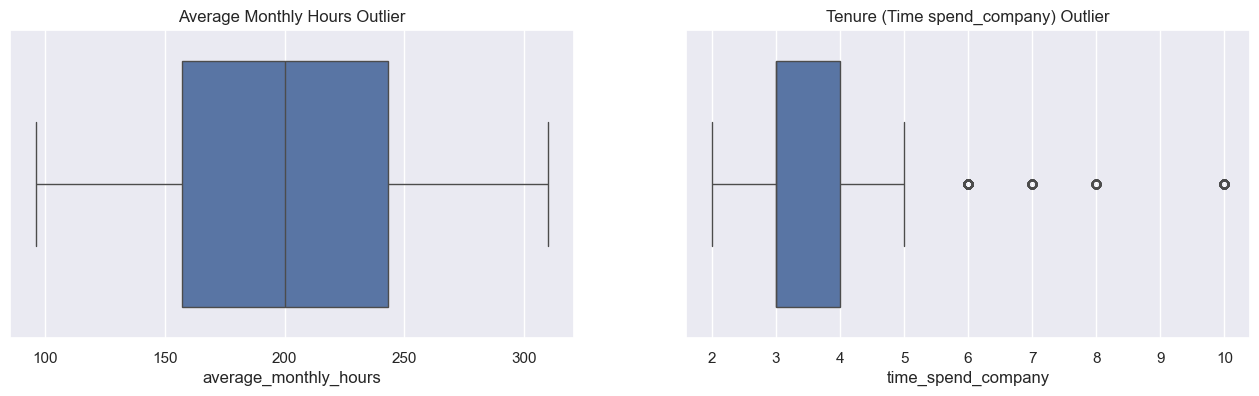

In [125]:
#visualizing outliers
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.set(style="darkgrid")
axes[0].set_title('Average Monthly Hours Outlier', fontsize = 12)
sns.boxplot(x=df['average_monthly_hours'], ax=axes[0])

axes[1].set_title('Tenure (Time spend_company) Outlier', fontsize = 12)
sns.boxplot(x=df['time_spend_company'], ax=axes[1])

In [126]:
#Calculate the IQR and outliers
percentile25 = df['time_spend_company'].quantile(.25)
percentile75 = df['time_spend_company'].quantile(.75)
iqr = percentile75-percentile25
lower_limit = percentile25 - 1.5*iqr
upper_limit = percentile75 + 1.5*iqr
print('Lower Limit:', lower_limit, ' |  Upper Limit:', upper_limit)

#Inspect outliers
outliers = df[(df['time_spend_company']<lower_limit) | (df['time_spend_company']> upper_limit)]
print('Number of Rows that Contain Outliers:', len(outliers))
print()
outliers.head()

Lower Limit: 1.5  |  Upper Limit: 5.5
Number of Rows that Contain Outliers: 824



,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
1,0.80,0.86,5,262,6,0,1,0,sales,medium
17,0.78,0.99,4,255,6,0,1,0,sales,low
34,0.84,0.87,4,246,6,0,1,0,hr,low
47,0.57,0.70,3,273,6,0,1,0,support,low
67,0.90,0.98,4,264,6,0,1,0,product_mng,medium


<span style="color:blue"> No need to remove outliers right now because the model we will use is still undetermined so far.
Certain models are sensitives to outliers, such as linear regression, K-NN, K-means clustering, and will require that we remove outliers before modeling.
However, other models such as tree based models, naive bayes are not sensitive to outliers and we would not need to remove the outliers before modeling.
This step is a part of EDA to get to know out dataset better.</span>

<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 3.5 EDA(Variables & Relationships)</h1>
</div>


Section 3.5 will inspect the correlations of the following variables

Variables|
-----|
left|
average_monthly_hours|
number_project|
promotion_last_5years|
salary|
satisfaction_level|
time_spend_company|

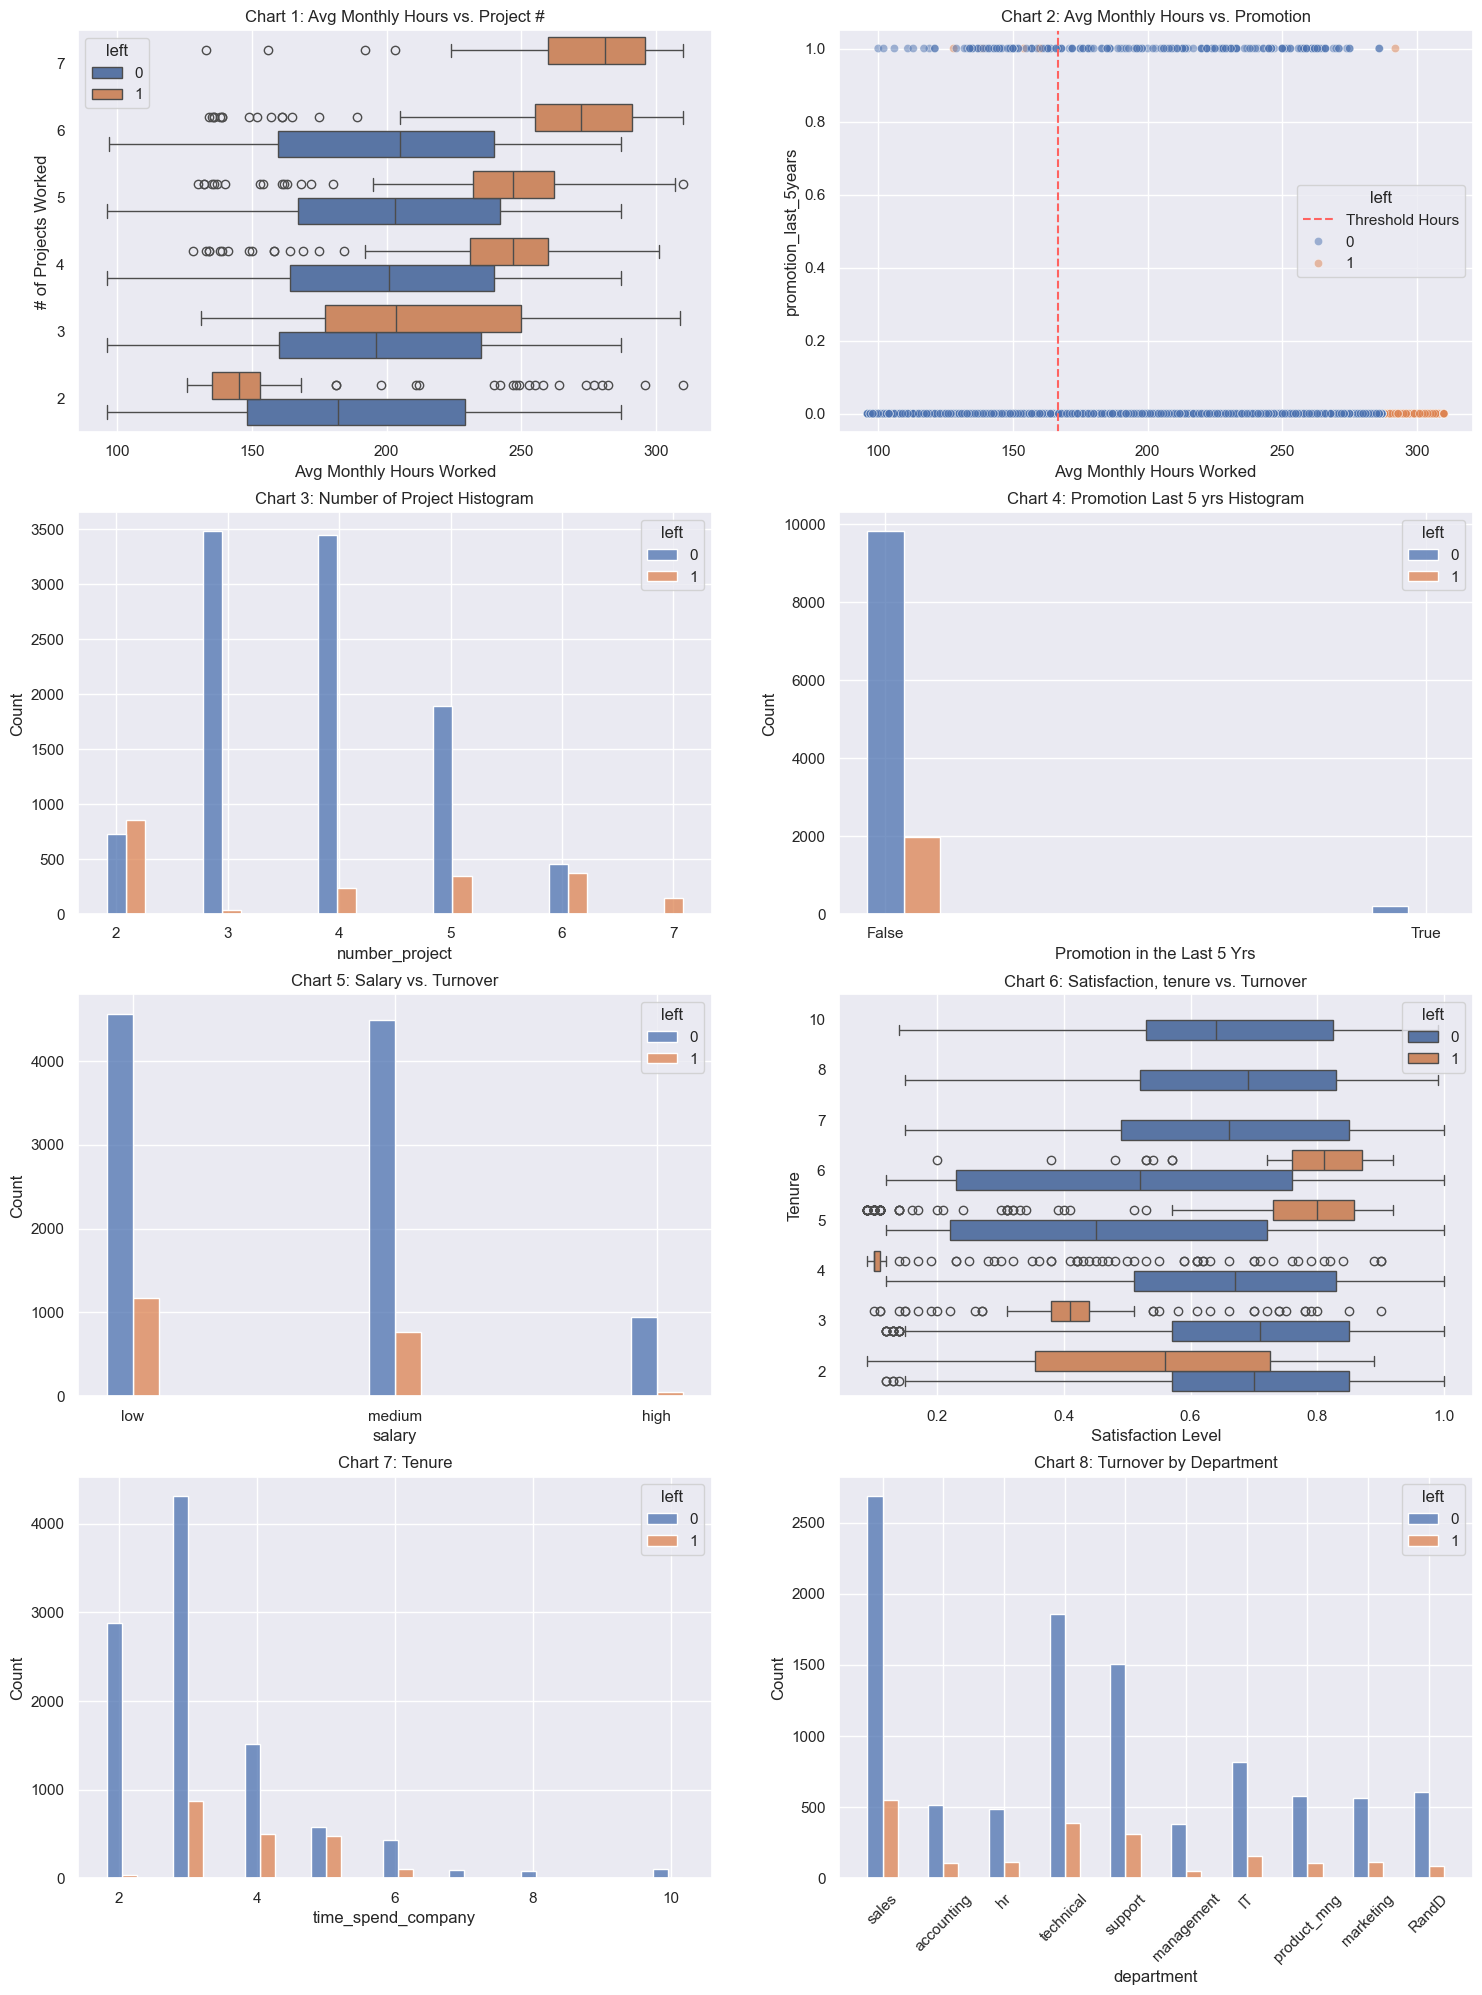

In [127]:
fig,axes = plt.subplots(nrows=4, ncols=2, figsize = (18, 24))
sns.set(style = 'darkgrid')

axes[0][0].set_title('Chart 1: Avg Monthly Hours vs. Project #',fontsize = 12)
sns.boxplot(data = df, x='average_monthly_hours', y = 'number_project', hue = 'left', orient ='h',ax=axes[0][0])
axes[0][0].invert_yaxis()
axes[0][0].set_xlabel('Avg Monthly Hours Worked')
axes[0][0].set_ylabel('# of Projects Worked')

axes[0][1].set_title('Chart 2: Avg Monthly Hours vs. Promotion',fontsize = 12)
axes[0][1].set_xlabel('Avg Monthly Hours Worked')
axes[0][1].axvline(x=166.67, color='#ff6361', ls='--', label = 'Threshold Hours')
axes[0][1].legend(labels=['Threshold Hours','stayed','left'])
sns.scatterplot(data = df, x='average_monthly_hours', y = 'promotion_last_5years', hue = 'left',alpha=0.5, ax=axes[0][1])

axes[1][0].set_title('Chart 3: Number of Project Histogram', fontsize = 12)
sns.histplot(data=df, x ='number_project', hue ='left', multiple ='dodge', shrink =2, ax=axes[1][0])

axes[1][1].set_title('Chart 4: Promotion Last 5 yrs Histogram', fontsize = 12)
axes[1][1].set_xticks([0, 1])
axes[1][1].set_xticklabels(['False', 'True'])
sns.histplot(data=df, x ='promotion_last_5years', hue ='left', multiple ='dodge', shrink =2, ax=axes[1][1])
axes[1][1].set_xlabel('Promotion in the Last 5 Yrs')

axes[2][0].set_title('Chart 5: Salary vs. Turnover', fontsize = 12)
sns.histplot(data=df, x ='salary', hue ='left', multiple ='dodge', shrink =0.2, ax=axes[2][0])

axes[2][1].set_title('Chart 6: Satisfaction, tenure vs. Turnover', fontsize = 12)
sns.boxplot(data=df, x ='satisfaction_level', y='time_spend_company', hue ='left', orient='h', ax=axes[2][1])
axes[2][1].set_xlabel('Satisfaction Level')
axes[2][1].set_ylabel('Tenure')
axes[2][1].invert_yaxis()

axes[3][0].set_title('Chart 7: Tenure', fontsize = 12)
sns.histplot(data=df, x ='time_spend_company', hue ='left', multiple ='dodge', shrink =5, ax=axes[3][0])

axes[3][1].set_title('Chart 8: Turnover by Department', fontsize=12)
sns.histplot(data=df, x='department', hue='left', multiple='dodge', shrink=0.5, ax=axes[3][1])
axes[3][1].tick_params(axis='x', rotation=45)

In [128]:
print('Turnover Rate - 7 Projects')
print(df[df['number_project']==7]['left'].value_counts(normalize=True),'\n')

print('Turnover Rate - No Promotion')
print(df[df['promotion_last_5years']==0]['left'].value_counts(normalize=True),'\n')

print('Turnover Rate - Promotion')
print(df[df['promotion_last_5years']==1]['left'].value_counts(normalize=True),'\n')

print('Turnover Rate - Salary')
print(df.groupby('salary')['left'].value_counts(normalize=True), '\n')


Turnover Rate - 7 Projects
left
1    1.0
Name: proportion, dtype: float64 

Turnover Rate - No Promotion
left
0    0.831778
1    0.168222
Name: proportion, dtype: float64 

Turnover Rate - Promotion
left
0    0.960591
1    0.039409
Name: proportion, dtype: float64 

Turnover Rate - Salary
salary  left
high    0       0.951515
        1       0.048485
low     0       0.795470
        1       0.204530
medium  0       0.853830
        1       0.146170
Name: proportion, dtype: float64 



In [129]:
pd.DataFrame(df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median]))

/var/folders/l1/_wpfw91x3_v1dkxzfb_546f40000gn/T/ipykernel_2312/957966419.py:1: FutureWarning: The provided callable <function mean at 0x106b81620> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.DataFrame(df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median]))
/var/folders/l1/_wpfw91x3_v1dkxzfb_546f40000gn/T/ipykernel_2312/957966419.py:1: FutureWarning: The provided callable <function median at 0x107045800> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  pd.DataFrame(df.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median]))


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


**Findings:**
1. The number of employees that leave the company increases as the number of projects one worked on increases.
2. There are employees who worked on significantly less projects (2) but still left. The reasons of this could be:<br>
    2.1 They were fired<br>
    2.2 They submitted the resignation letter, which resulted in a reduction of project assignment.
3. Aside from 2 and 7 projects, the turnover rate increases as the # of projects increases.
4. Everyone with 7 projects left the company. It is reasonable to infer that they quit.
5. The most common numbers of projects to work on are 3~5.
6. Almost all employees overworked.<br>
    6.1 If we assume a work week of 40hrs and each employee only takes 2 weeks off in a year, the average number of working hours per month ≈ 166.67   hours/month. If we divide the employees based on the number of projects they've worked on, all groups worked considerably more hours.
7. Very few people who got promoted in the last 5 years left. 16% of the employees who did not get a promotion in the last 5 years left; while only 3% of the employees who got a promotion in the last 5 years left.
8. Very few people who worked the most hours were promoted.
9. All emplpoyees who left were working the longest hours.
10. The turnover rate for employees with higher salary(4%) is lower compared to employees with medium(14%) and low(20%).
11. Four-year employees who left seem to have an unusually low satisfaction level. This is worth further investigation such as management change, policy change, etc.
12. The employees with the longest tenures don't leave, but their satisfaction level is not significantly higher than other tenure groups either.
13. For those who stayed, the mean satisfaction score is a bit lower than the median, this indicates that the satisfaction score among those who did not leave might be skewed to the left.
14. There are very few employees who have a tenure over 8 years. It is possible that they are higher ranking employees/executives.
15. The sales department has the most employees who left the company but the number is not disproportionate.

<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 3.6 EDA(Variables Correlations)</h1>
</div>


[Text(0.5, 0, 'satisfaction_level'),
 Text(1.5, 0, 'last_evaluation'),
 Text(2.5, 0, 'number_project'),
 Text(3.5, 0, 'average_monthly_hours'),
 Text(4.5, 0, 'time_spend_company'),
 Text(5.5, 0, 'work_accident'),
 Text(6.5, 0, 'left'),
 Text(7.5, 0, 'promotion_last_5years')]

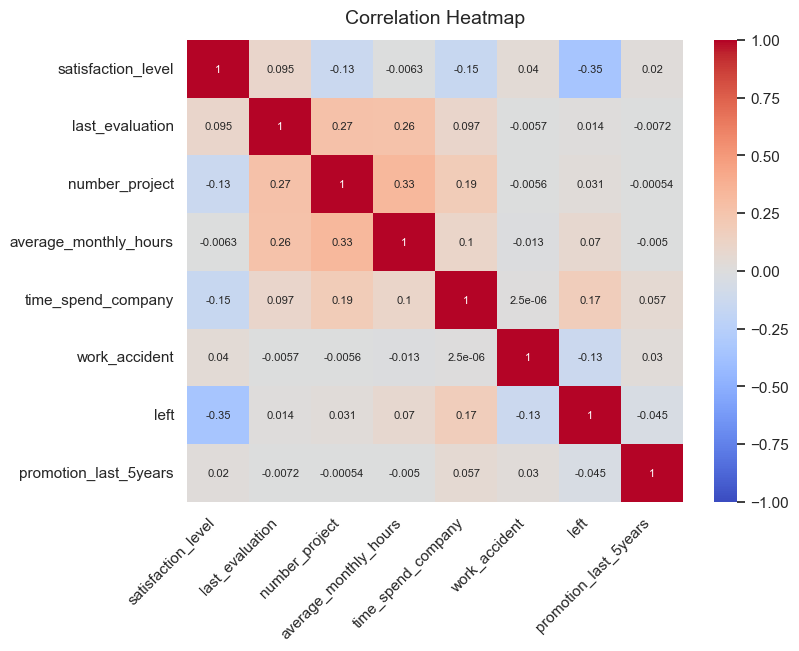

In [130]:
#use a heatmap to see correlations
df_heatmap = df.copy().drop(columns=['department','salary'])
plt.figure(figsize=(8,6))
heatmap=sns.heatmap(df_heatmap.corr(), annot=True, annot_kws={"size": 8},vmin=-1, vmax=1, cmap=sns.color_palette('coolwarm', as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

The heatmap indicates that number of projects, average monthly hours, and last evaluation score have positive correlation with each other; whether an employee leaves the company is negatively correlated with satisfaction level.



<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 4.1  Model A - Logistic Regression</h1>
</div>

This section determines which models are the most appropriate, builds the models and confirm the assumptions. <br>

Our goal is to predict whether or not an employee will leave the company, which is a binary classification,hence we can build either a Logistic Regression Model or a Tree-based Machine Learning model.<br><br>
**Assumption 1. Logistic Regression**<br>
In order to build a logistic regression model, the data we use must meet the following requirements.
1. Sufficient data (Met)
2. Outcome variable is categorical.(Met)
3. Observations are independent of each other (Can keep the ones that are. Met)
4. No severe multicollinearity among x variables. (We can select the variables we use. Met)
5. No extreme outliers. (824 rows contain outliers, and we can drop these rows as this is only 5% of the total data. Met)
6. Linear relationship between each x variable and the logit of the outcome variable. 
logit(p)=log(p/(1-p))(Will test below)

In [131]:
#encode the dataset 
#manually encode the "salary" column as it is ordinal
df_encoded = df.copy()
df_encoded['salary'] = df_encoded['salary'].astype('category').cat.set_categories(['low','medium','high'], ordered =True).cat.codes

#dummy encode the 'department'column
df_encoded = pd.get_dummies(df_encoded, drop_first = True)
df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False


In [132]:
#remove outliers
df_log = df_encoded[(df_encoded['time_spend_company']>=lower_limit) & (df_encoded['time_spend_company']<=upper_limit)]
df_log.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,True,False,False


In [133]:
#The df_log dataset should contain 14999(original) - duplicate(3008) - outlier(824) = 11167 rows.
df_log.shape

(11167, 18)

In [134]:
#isolate the y variable
y = df_log['left']
y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [135]:
#isolate the x variables
x = df_log.drop(columns =['left'], axis =1)
x.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,True,False,False


In [136]:
#split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=0)

In [137]:
#construct a logistic regression model
log_clf=LogisticRegression(random_state = 0, max_iter=500).fit(x_train, y_train)

In [138]:
#use the model to predict the test dataset
y_pred = log_clf.predict(x_test)

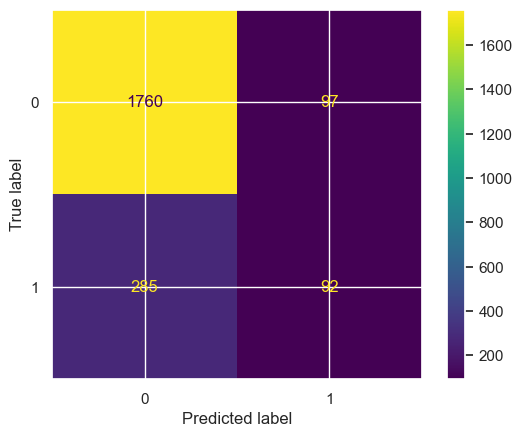

In [139]:
#use Confusion Matrix to evaluate the model
log_cm= confusion_matrix(y_test, y_pred, labels = log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels = log_clf.classes_)
log_disp.plot()
plt.show()

True Negatives: 1761. The number of employees who did not leave the company that the model correctly predicted so.
False Positives: 96. The number of employees who did not leave the company that the model incorrectly predicted otherwise.
False Negatives: 288. The number of employees who left the company that the model incorrectly predicted otherwise.
True Positives: 89. The number of employees who left the company that the model correctly predicted so.

The most ideal model would have no F+ and F- and only yield T+ and T-.

In [140]:
#get the class balance data
df_log['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

The T/F split is approximately 83%-17%, which is not perfectly balanced but is not extrememly imbalanced either. No modification is needed with a 83-17 ratio data balance.

In [141]:
#get the accuracy score, precision score, recall score, and F1 score.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1857
           1       0.49      0.24      0.33       377

    accuracy                           0.83      2234
   macro avg       0.67      0.60      0.61      2234
weighted avg       0.80      0.83      0.80      2234



For class 0, the model demonstrates strong performance with a precision of 0.86 (the proportion of correctly predicted positive instances among all instances predicted as positive), recall of 0.95 (the proportion of correctly predicted positive instances among all actual positive instances), and an F1-score of 0.90 (a balanced measure of precision and recall). However, for class 1, the model's performance is weaker, with lower precision (0.48), recall (0.24), and F1-score (0.32), indicating difficulty in correctly identifying instances of class 1. The overall accuracy is 0.83 (the proportion of correctly predicted instances out of the total), and the macro and weighted averages provide additional summary measures across classes, suggesting an imbalanced performance favoring class 0.

<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 4.2  Model B - Decision Tree (Round 1)</h1>
</div>

In [142]:
#isolate the y variable
y = df_encoded['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [143]:
x=df_encoded.drop('left', axis=1)
x.head(2)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,True,False,False


In [144]:
#split the data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify = y, random_state = 0)

**Tree-based Model Approach 1 - Use Cross Validation**

In [145]:
tree = DecisionTreeClassifier(random_state=0)
cv_params = {'max_depth':[4,6,8,10, None],
            'min_samples_split':[2,4],
            'min_samples_leaf':[1,2,3]
            }
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
tree = GridSearchCV(tree, cv_params, scoring = scoring, cv=5, refit='roc_auc')

We use 'roc_auc' as our evaluation metric because ROC AUC may be a good choice when the cost of false positives and false negatives is not significantly different, and you want to evaluate the model's overall discriminative ability.

In [146]:
%%time
tree.fit(x_train, y_train)

CPU times: user 2.23 s, sys: 830 ms, total: 3.06 s
Wall time: 2.08 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, 10, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [147]:
#get the best parameters
tree.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [148]:
#check the best AUC score from the Cross Validation
tree.best_score_

0.973056669823953

0.97 is a high AUC score, which means that this model can predict if an employee will leave the company very well.

In [149]:
def get_results(model_name:str, model_object, metric:str):
    metric_dict = {'accuracy':'mean_test_accuracy',
                  'precision':'mean_test_precision',
                  'recall':'mean_test_recall',
                  'f1':'mean_test_f1',
                  'roc_auc':'mean_test_roc_auc'}
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]
    table = pd.DataFrame({'Model Name':[model_name],
                         'accuracy':[best_estimator_results['mean_test_accuracy']],
                         'precision':[best_estimator_results['mean_test_precision']],
                         'f1': [best_estimator_results['mean_test_f1']],
                         'roc_auc':[best_estimator_results['mean_test_roc_auc']]})
    return table

In [150]:
tree_cv_results = get_results('Decision Tree CV', tree, 'roc_auc')
tree_cv_results

,Model Name,accuracy,precision,f1,roc_auc
0,Decision Tree CV,0.982173,0.9709,0.944888,0.973057


This table showcase the accuracy score, precision score, f1 score, along with the ROC AUC score of the tree1 decision tree model for where "ROC AUC" score is the highest amongst the models evaluated.
However, decision trees are prone to overfitting, meaning that they may capture noise in the training data and not generalize well to new, unseen data. They can be sensitive to variations in the training data. <br><br>
Random Forest is an ensemble of decision trees and combine their outputs to make a more robust and accurate prediction. Random Forest introduces randomness by training each tree on a random subset of the training data and consiering a random subset for each split. This helps to reduce overfitting and improve generalization. 

<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 4.3  Model C - Random Forest</h1>
</div>

In [151]:
#Initiate the Random Forest Model
rf=RandomForestClassifier(random_state=0)

#Define a dictionary of hyperparameters to search over and assign it to a variable
cv_params = {'max_depth':[3,5,None],
            'max_features':[None],
            'max_samples':[0.5, 0.7, None],
            'min_samples_leaf':[1,2],
            'min_samples_split':[2,3,4],
            'n_estimators':[300, 450]
            }
#Define a dictionary of scoring metrics and assign it to a variable
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

#Instantiate the GridSearch
rf=GridSearchCV(rf, cv_params, scoring = scoring, cv=5, refit='roc_auc')

In [152]:
# %%time
rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [None],
                         'max_samples': [0.5, 0.7, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 450]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [153]:
#define 2 function for both saving a model and reading a model
path = 'Portforlio Project 1 - Salifort Motor Employee Retention/'

def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model

In [154]:
#pickle our random forest model
write_pickle(path, rf, 'salifort_motor_hr_rf')

In [155]:
#Read the pickle
rf = read_pickle(path, 'salifort_motor_hr_rf')

In [156]:
#identify the best roc_auc score and best parameters from the rf
best_score = rf.best_score_
best_params = rf.best_params_
write_pickle(path, best_score, 'rf_best_score')
write_pickle(path, best_params, 'rf_best_params')

Now we want to compare the performance of the decision tree model and the random forest model.

In [157]:
display(tree_cv_results)
rf_results = get_results('random_forest_cv', rf, 'roc_auc')
rf_results

,Model Name,accuracy,precision,f1,roc_auc
0,Decision Tree CV,0.982173,0.9709,0.944888,0.973057


,Model Name,accuracy,precision,f1,roc_auc
0,random_forest_cv,0.977689,0.950464,0.931494,0.980507


It appears that both models perform well, but the "Decision Tree CV" model generally has higher metrics for accuracy, precision, and f1 score. The random forest model has higher ROC_AUC score. 

Next, evaluate the model with the test dataset. Define a function to get the scores directly from the prediction so we get the scores of all future predictions with high efficiency.

In [158]:
def get_prediction_scores(model_name:str, model, x_test_data, y_test_data):
    #make prediction
    pred = model.best_estimator_.predict(x_test_data)
    table = pd.DataFrame({'Model':[model_name],
                          'accuracy':accuracy_score(y_test_data, pred),
                          'precision':precision_score(y_test_data, pred),
                          'recall':recall_score(y_test_data, pred),
                          'f1': f1_score(y_test_data, pred),
                          'roc_auc':roc_auc_score(y_test_data, pred)
                          })
    return table

In [159]:
rf_test_score = get_prediction_scores('Random Forest Model Test', rf, x_test, y_test)
rf_test_score

,Model,accuracy,precision,recall,f1,roc_auc
0,Random Forest Model Test,0.979992,0.960526,0.917085,0.938303,0.954795


According to the scores, this appears to be a strong model. Since this test was only reserved and used for this model, we can be confident that the model's performance on this data is representative of how it will perform on new, unseen data.

Feature Engineering <br>
Even though the previous 2 models have high performance scores, we may need to be a little skeptical of some of the features we used.<br>
The first one is "satisfaction level." It is likely that the company didn't have the satisfaction level reported for all employees.
The second feature is "average_monthly_hours", which itself could be affected by the outcome we are trying to predict. If an employee has already decided to quit, or has been identified as people to be fired, they may be working fewer hours as a result.<br>
This is where feature engineering comes in, where we engineer the features to address these issues and reevaluate a model's performance.
Strategy:<br>
1. dropping the satisfaction level feature
2. creating a new binary feature with "avarage_monthly_hours"


In [160]:
#drop the satisfaction level column
df1 = df_encoded.drop('satisfaction_level', axis =1)

In [161]:
df1.head(3)

,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False


In [162]:
df1['overworked']=df1['average_monthly_hours']

In [163]:
#convert "overworked" column values to boolean (0/1)
df1['overworked']=(df1['overworked']>175).astype(int)

In [164]:
df1.head()

,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False,0
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False,1
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False,1
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False,1
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False,0


In [165]:
#start modeling again by isolating x and y
y = df1['left']
x = df1.drop('left', axis=1)

In [166]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, stratify=y)

<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 4.2  Model D - Decision Tree (Round 2)</h1>
</div>

In [167]:
tree1 = DecisionTreeClassifier(random_state=0)
cv_params1 = {'max_depth':[4, 6, None],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2, 4, 6]
             }
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
tree1= GridSearchCV(tree1, cv_params1, scoring = scoring, cv=5, refit='roc_auc')

In [168]:
%%time
tree1.fit(x_train, y_train)

CPU times: user 1.51 s, sys: 5.02 ms, total: 1.51 s
Wall time: 1.54 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [169]:
tree1. best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}

In [170]:
tree1.best_score_

0.9653191959776436

In [171]:
tree1_cv_results = get_results('Decision Tree Round 2', tree1, 'roc_auc')
display(tree_cv_results)
display(tree1_cv_results)

,Model Name,accuracy,precision,f1,roc_auc
0,Decision Tree CV,0.982173,0.9709,0.944888,0.973057


,Model Name,accuracy,precision,f1,roc_auc
0,Decision Tree Round 2,0.966086,0.888693,0.899486,0.965319


<div style="background-color: #F0F0F0; padding: 10px;">
    <h1 style="text-align: center; color: #800020; font-size: 20px;">Section 4.3  Model E - Random Forest (Round 2)</h1>
</div>

In [172]:
rf1=RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,4],
             'n_estimators': [300, 450],
             } 
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
rf1 = GridSearchCV(rf1, cv_params1, scoring = scoring, cv=5, refit='roc_auc')

In [179]:
%%time
rf1.fit(x_train, y_train)

CPU times: user 25.4 s, sys: 128 ms, total: 25.5 s
Wall time: 25.9 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [180]:
write_pickle(path, rf1, 'random_forest_round2')

In [175]:
read_pickle(path, 'random_forest_round2')

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [181]:
rf1_best_params = rf1.best_params_
rf1_best_score = rf1.best_score_
rf1_best_estimator = rf1.best_estimator_
write_pickle(path, rf1_best_score, 'rf1_best_score')
write_pickle(path, rf1_best_params, 'rf1_best_params')
write_pickle(path, rf1_best_estimator, 'rf1_best_estimator')

In [182]:
rf1_cv_results = get_results('Random Forest Round 2', rf1, 'roc_auc')
display(tree1_cv_results)
display(rf1_cv_results)

,Model Name,accuracy,precision,f1,roc_auc
0,Decision Tree Round 2,0.966086,0.888693,0.899486,0.965319


,Model Name,accuracy,precision,f1,roc_auc
0,Random Forest Round 2,0.972645,0.944381,0.914936,0.975134


After comparing the 2nd round of "Decision Tree Model" and "Random Forest Model", we noticed that the "Random Forest Model" outperforms in every metric. We will use this model on our test dataset.

In [183]:
rf1_get_scores = get_prediction_scores('Random Forest Round 2', rf1, x_test, y_test)
rf1_get_scores

,Model,accuracy,precision,recall,f1,roc_auc
0,Random Forest Round 2,0.971981,0.93125,0.89759,0.91411,0.942195


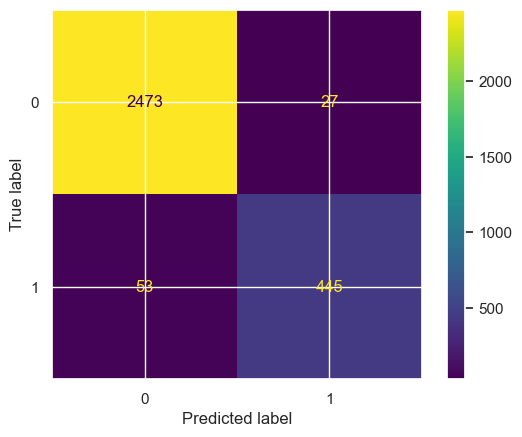

In [ ]:
pred = rf1.best_estimator_.predict(x_test)
cm =confusion_matrix(y_test, pred, labels = rf1.classes_)
disp=ConfusionMatrixDisplay(cm, display_labels=rf1.classes_)
disp.plot()

This round of random forest model predict more TP and TN than FP and FN, which means that this is a strong model. This model also predicts more FN than FP, which means that there will be employees identified as "will quit" will not actually quit.

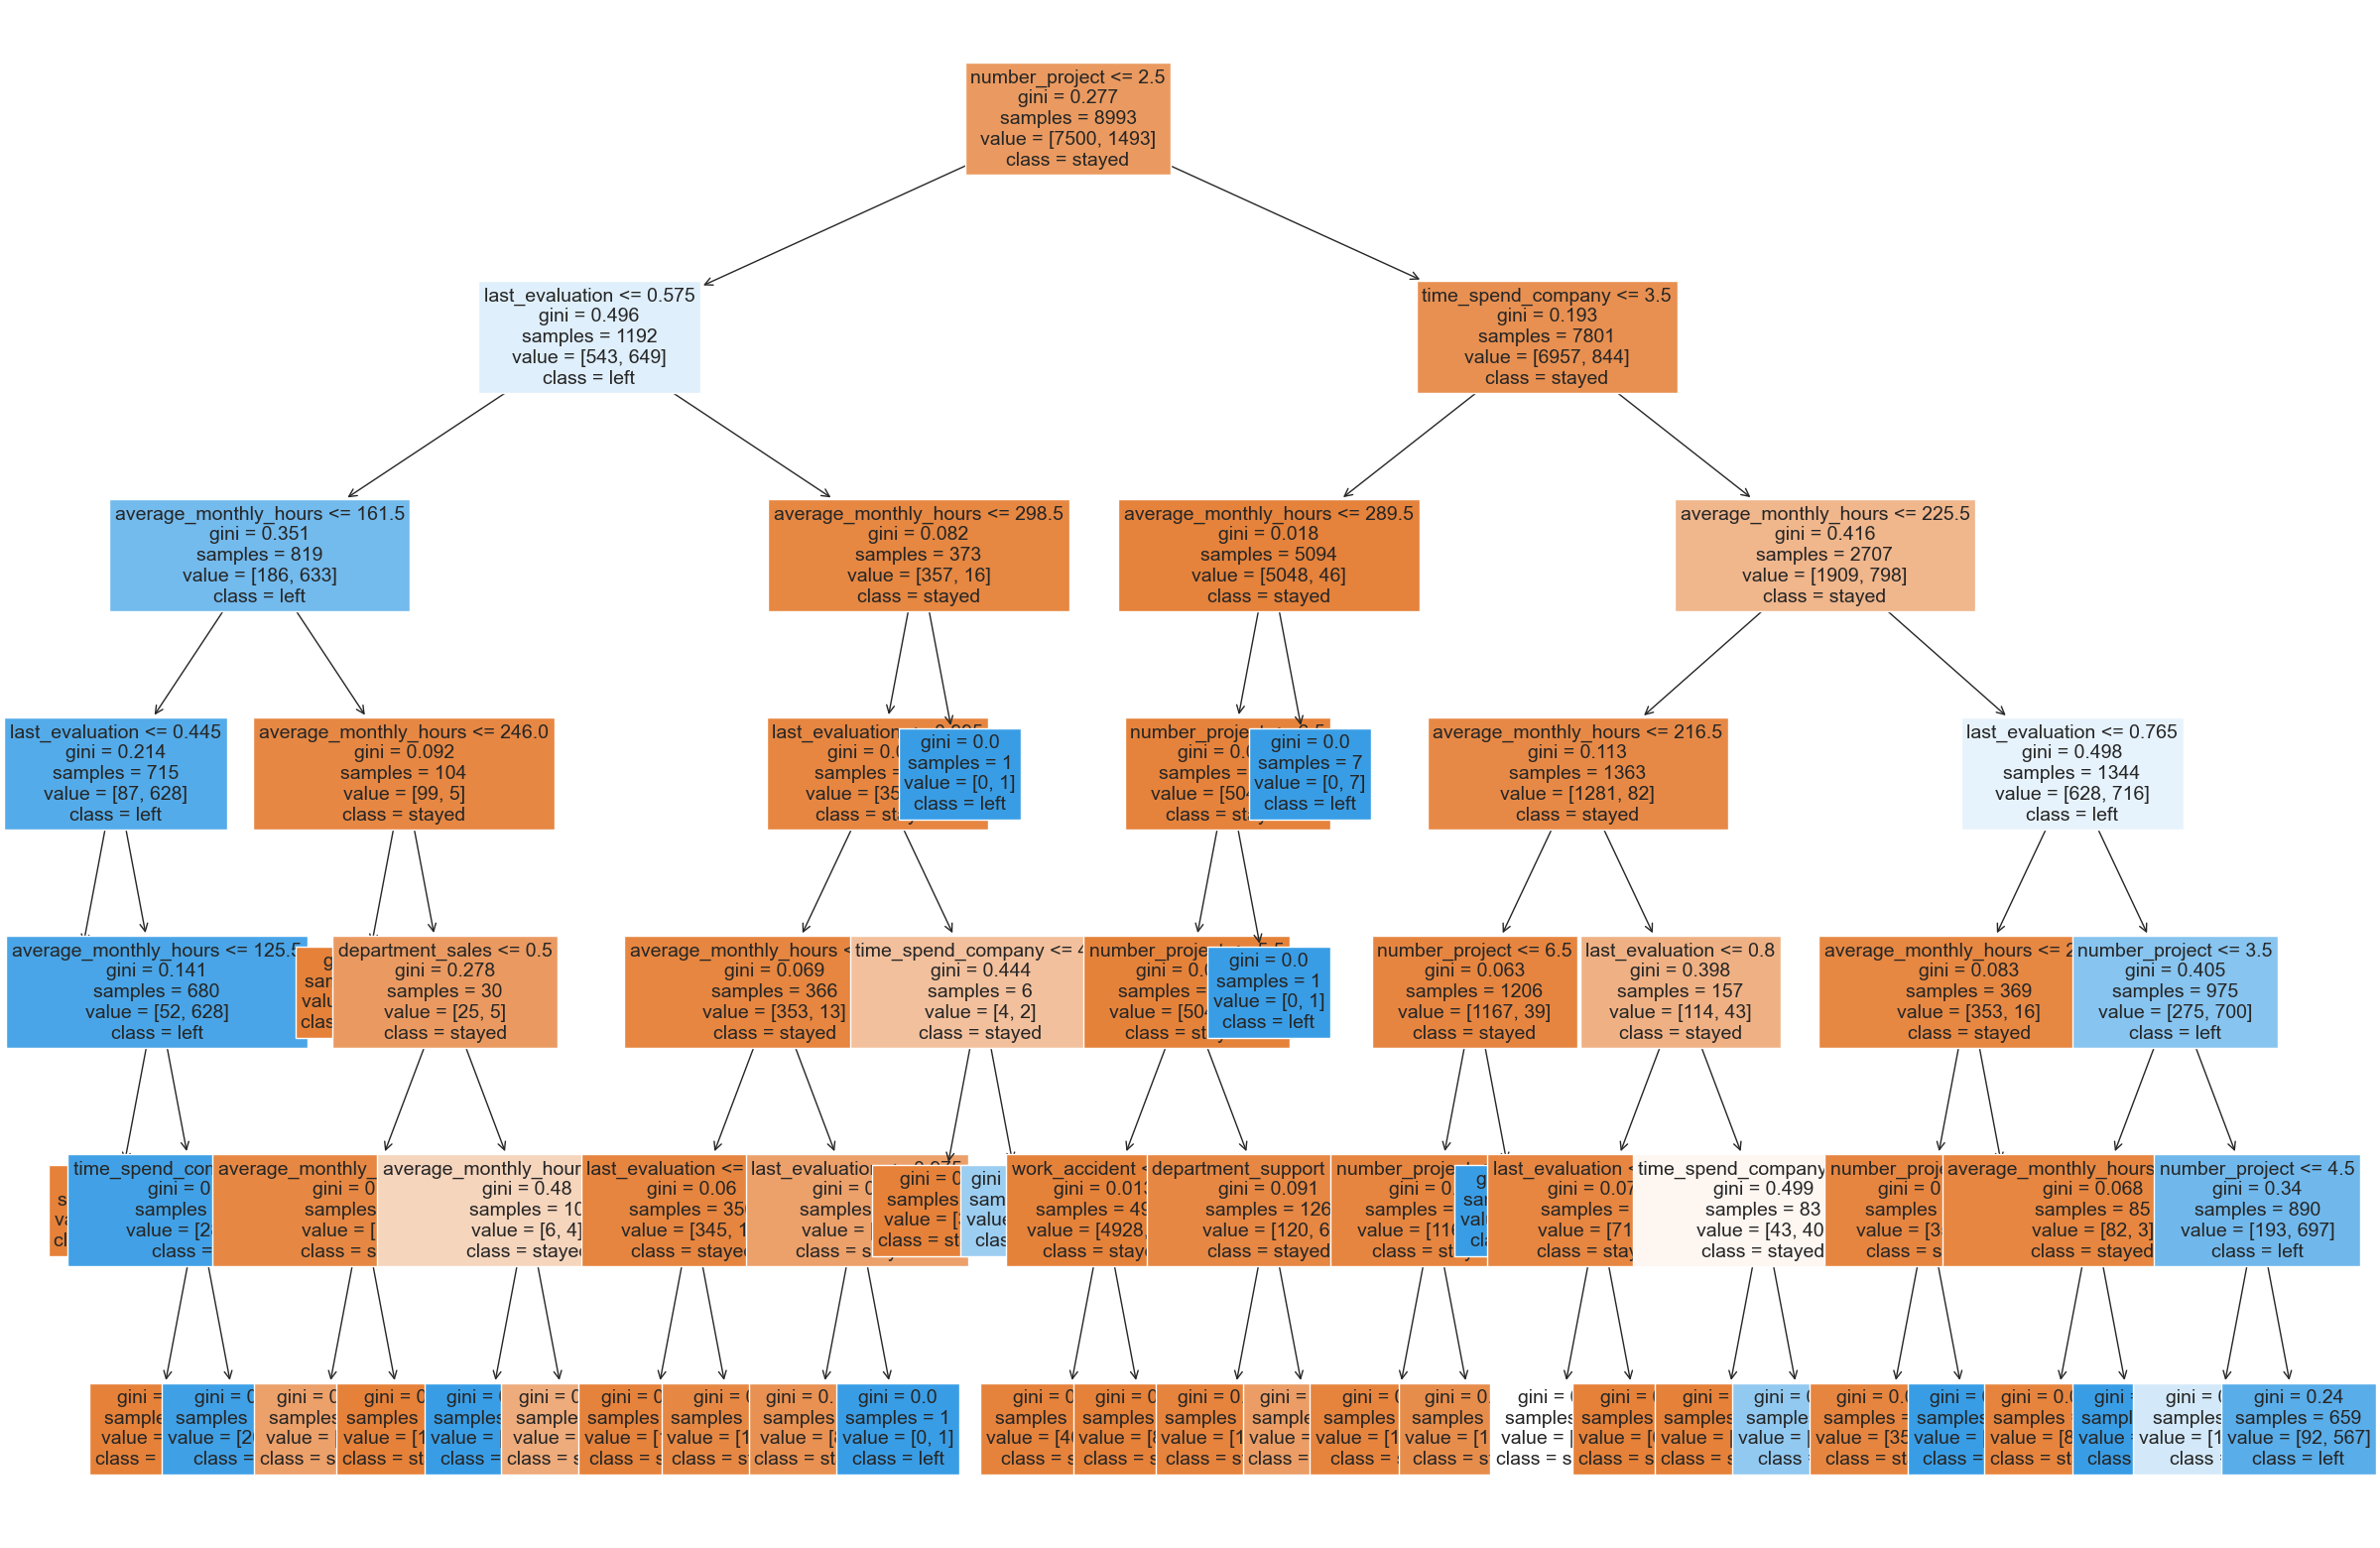

In [184]:
# Plot the tree
plt.figure(figsize=(30,20))
# plot_tree(tree1.best_estimator_, max_depth=None, fontsize=14, feature_names=x.columns, 
#           class_names={0:'stayed', 1:'left'}, filled=True);
plot_tree(tree1.best_estimator_, fontsize=14, feature_names=x.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [189]:
#Decision Tree Feature Importances
tree1_feature_importances = pd.DataFrame(tree1.best_estimator_.feature_importances_, 
                                         columns = ['gini_importance'], 
                                         index=x.columns).sort_values(by='gini_importance', ascending = False)
tree1_feature_importances

,gini_importance
last_evaluation,0.304339
number_project,0.266073
average_monthly_hours,0.263612
time_spend_company,0.164620
department_sales,0.000836
department_support,0.000492
work_accident,0.000029
department_marketing,0.000000
department_technical,0.000000
department_product_mng,0.000000


Text(0, 0.5, 'Features/Factors')

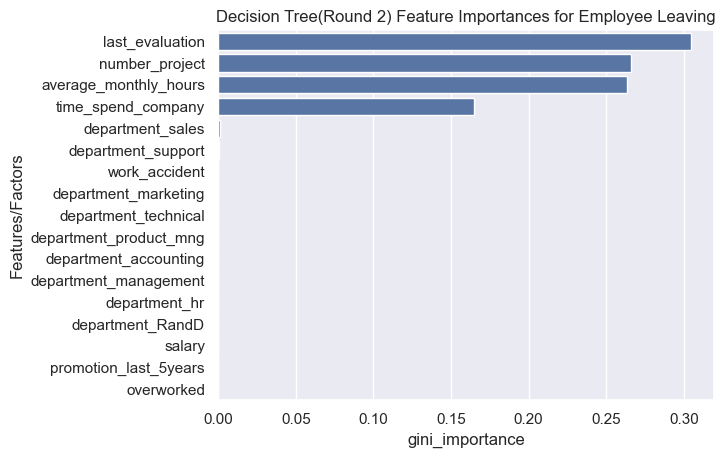

In [197]:
sns.barplot(tree1_feature_importances, x ='gini_importance', y=tree1_feature_importances.index)
plt.title('Decision Tree(Round 2) Feature Importances for Employee Leaving')
plt.ylabel('Features/Factors')

The barplot above shows that in the second round Decision Tree model, "last evaluation", "number_project", "average_monthly_hours", "time_spend_company" are the top 4 factors/have the highest feature importance.

In [210]:
#Get and plot the feature importances for the second round of Random Forest Model to compare and validate the feature importance from the Decision Tree Model.
rf1_feature_importances = pd.DataFrame(rf1.best_estimator_.feature_importances_, 
                                       columns = ['rf1_gini_importance'], 
                                       index=x.columns).sort_values(by = 'rf1_gini_importance', ascending = False)

rf1_feature_importances


,rf1_gini_importance
number_project,0.291721
average_monthly_hours,0.220724
time_spend_company,0.204520
last_evaluation,0.192452
overworked,0.041600
salary,0.015670
work_accident,0.012404
department_technical,0.003661
department_sales,0.003604
department_support,0.003097


Text(0, 0.5, 'Features/Factors')

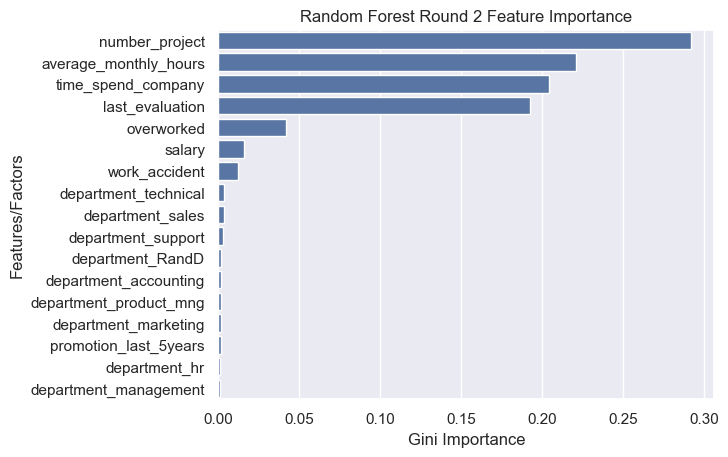

In [219]:
# sns.barplot(data=rf1_feature_importances, x='rf1_gini_importance', y=x.columns)
sns.barplot(data=rf1_feature_importances, x='rf1_gini_importance', y=rf1_feature_importances.index)
plt.title('Random Forest Round 2 Feature Importance')
plt.xlabel('Gini Importance')
plt.ylabel('Features/Factors')